In [1]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

import getpass


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def build_bv_circuit(secret: str) -> QuantumCircuit:
    n = len(secret)
    q = QuantumRegister(n + 1, "q")     # n inputs + 1 ancilla
    c = ClassicalRegister(n, "meas")    # name the classical register
    qc = QuantumCircuit(q, c)

    # ancilla to |−>
    qc.x(q[n])
    qc.h(q[n])

    # Hadamards on inputs
    qc.h(q[:n])

    # Oracle: CX for each '1' bit
    for i, bit in enumerate(secret):
        if bit == "1":
            qc.cx(q[i], q[n])

    # Final H and measure inputs
    qc.h(q[:n])
    qc.measure(q[:n], c)
    return qc



In [3]:
def run_locally(secret, shots=1024):
    qc = build_bv_circuit(secret)
    sim = AerSimulator()
    result = sim.run(qc, shots=shots).result()
    counts = result.get_counts()
    plot_histogram(counts)
    return counts

secret = input("Enter a binary string (e.g., 1011): ").strip()
local_counts = run_locally(secret)
print("Local Simulator Result:", local_counts)



Enter a binary string (e.g., 1011):  10010


Local Simulator Result: {'01001': 1024}


In [4]:
# Paste your API key here or enter securely
token = getpass.getpass("Enter your IBM Quantum API token: ")

# Use IBM Quantum Platform channel (or 'ibm_cloud' if you’re on IBM Cloud)
service = QiskitRuntimeService(channel="ibm_quantum_platform", token=token)

# List available backends
service.backends()


Enter your IBM Quantum API token:  ········


qiskit_runtime_service._discover_account:WARNING:2025-11-07 22:56:45,504: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2025-11-07 22:56:50,606: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-07 22:56:50,609: Loading instance: open-instance, plan: open


[<IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_marrakesh')>,
 <IBMBackend('ibm_torino')>]

In [5]:
def pick_least_busy_hw(service, qubits_needed):
    choices = []
    for b in service.backends():
        if "simulator" in b.name.lower():
            continue
        if getattr(b, "num_qubits", 0) >= qubits_needed:
            try:
                pending = getattr(b.status(), "pending_jobs", 999999)
                choices.append((pending, b))
            except:
                pass
    if not choices:
        raise RuntimeError("No suitable hardware.")
    choices.sort(key=lambda x: x[0])
    return choices[0][1]

backend = pick_least_busy_hw(service, len(secret)+1)
print("Selected hardware backend:", backend.name, "| pending jobs:", backend.status().pending_jobs)


qiskit_runtime_service.backends:WARNING:2025-11-07 22:56:51,307: Loading instance: open-instance, plan: open


Selected hardware backend: ibm_fez | pending jobs: 13


{'01000': 8, '11001': 2, '01001': 223, '00001': 4, '01011': 5, '00000': 2, '01101': 3, '01010': 2, '01111': 1, '10000': 2, '11100': 1, '11000': 2, '01110': 1}


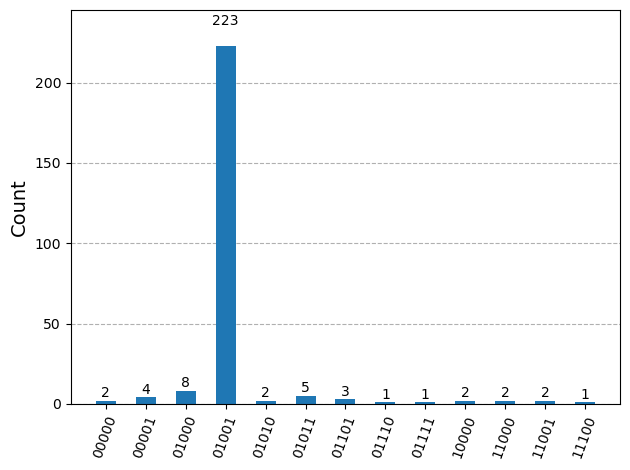

In [6]:
from qiskit import transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram

qc = build_bv_circuit(secret)

isa_qc = transpile(qc, backend=backend, optimization_level=0)
sampler = Sampler(mode=backend)
job = sampler.run([isa_qc], shots=256)
res = job.result()

# ✅ Works across recent SamplerV2 versions:
pub = res[0]
counts = pub.join_data().get_counts()   # merges all classical regs (ours is "meas")
print(counts)
plot_histogram(counts)



In [7]:
print(f"✅ The Bernstein–Vazirani algorithm successfully found your secret string '{secret}' in one query!")


✅ The Bernstein–Vazirani algorithm successfully found your secret string '10010' in one query!
